Custom types registration
=========================

By calling `fiatlight.register_type(DataType, DataTypeWithGui)`, it is possible to register a custom type with its GUI.

For a given type's GUI, it is possible to customize many aspects. Basically all the callbacks and options inside [AnyDataGuiCallbacks](api_any_data_gui_callbacks.ipynb) can be customized.


Example 1: a customizable Normal Distribution type
--------------------------------------------------

**Step 1: Define the Custom Type**

First, let’s define a new type called NormalDistribution.

In [1]:
class NormalDistribution:
    mean: float = 0.0
    stddev: float = 1.0

    def __init__(self, mean: float = 0.0, stddev: float = 1.0) -> None:
        self.mean = mean
        self.stddev = stddev

**Step 2: Create a Class to Handle the Custom Type**

Next, we create a class NormalDistributionWithGui that extends AnyDataWithGui and defines the custom presentation and editing logic for the NormalDistribution type.

It will handle:
- A custom GUI for editing the NormalDistribution type
- A custom GUI for presenting the NormalDistribution type
  (using a cached figure, which is updated when the distribution changes)
- Serialization and deserialization of the custom type
- A default value provider

In [2]:
import fiatlight as fl
from imgui_bundle import imgui, imgui_fig
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np


class NormalDistributionWithGui(fl.AnyDataWithGui[NormalDistribution]):
    # Cached figure for the distribution plot
    figure: Figure | None = None
    # boolean to indicate if the figure image should be refreshed
    shall_refresh_figure_image: bool = True

    def __init__(self) -> None:
        super().__init__(NormalDistribution)

        # Edit and present callbacks
        self.callbacks.edit = self._edit_gui
        self.callbacks.present = self._present_gui
        self.callbacks.present_str = lambda value: f"Normal Distrib: Mean={value.mean:.2f}, StdDev={value.stddev:.2f}"

        # Default value provider
        self.callbacks.default_value_provider = lambda: NormalDistribution()

        # Serialization of the custom type
        # (note it would be automatic if we used a Pydantic model)
        self.callbacks.save_to_dict = lambda value: {"mean": value.mean, "stddev": value.stddev}
        self.callbacks.load_from_dict = lambda data: NormalDistribution(mean=data["mean"], stddev=data["stddev"])

        # Callback for handling changes: we need to subscribe to this event
        # in order to update the self.figure when the distribution changes
        self.callbacks.on_change = self._on_change

    def _on_change(self, value: NormalDistribution) -> None:
        # remember to close the previous figure to avoid memory leaks
        if self.figure is not None:
            plt.close(self.figure)

        # Create the figure
        x = np.linspace(value.mean - 4 * value.stddev, value.mean + 4 * value.stddev, 100)
        y = (1 / (value.stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - value.mean) / value.stddev) ** 2)
        figure = plt.figure(figsize=(4, 3))
        plt.plot(x, y)
        plt.title("Normal Distribution")
        plt.xlabel("x")
        plt.ylabel("Density")
        plt.grid(True)

        # Cache the figure
        self.figure = figure

        # Indicate that the figure image should be refreshed
        self.shall_refresh_figure_image = True

    @staticmethod
    def _edit_gui(value: NormalDistribution) -> tuple[bool, NormalDistribution]:
        # Note: we receive the current value and return a tuple with
        # a boolean indicating if the value was modified
        modified = False
        imgui.text("Edit Normal Distribution:")
        imgui.set_next_item_width(100)
        changed, new_mean = imgui.slider_float("Mean", value.mean, -10.0, 10.0)
        if changed:
            value.mean = new_mean
            modified = True
        imgui.set_next_item_width(100)
        changed, new_stddev = imgui.slider_float("StdDev", value.stddev, 0.1, 10.0)
        if changed:
            value.stddev = new_stddev
            modified = True

        return modified, value

    def _present_gui(self, _value: NormalDistribution) -> None:
        # We do not use the value which was passed as a parameter as we use the cached Figure
        # which was updated in the _on_change callback
        imgui_fig.fig("Normal Distribution", self.figure, refresh_image=self.shall_refresh_figure_image)
        self.shall_refresh = False

**Step 3: Register the type**

Finally, we register the custom type with its GUI, simply by calling the register_type function.

In [3]:
fl.register_type(NormalDistribution, NormalDistributionWithGui)

From now on, the NormalDistribution type will be associated with the NormalDistributionWithGui GUI:
any function that uses NormalDistribution as a parameter or as a return type will automatically have a GUI for editing and presenting the NormalDistribution type.

**Step 4: Use the custom type in a function**

In this example, our function simply returns the NormalDistribution instance that was passed to it.
In the screenshot, you can see the "edit" callback in action in the Param edition section, and the "present" callback in the Output section.

2024-07-04 23:40:32.252 Python[68193:11625526] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/w1/w77kvvl9613022ksfxj7v8xh0000gn/T/org.python.python.savedState


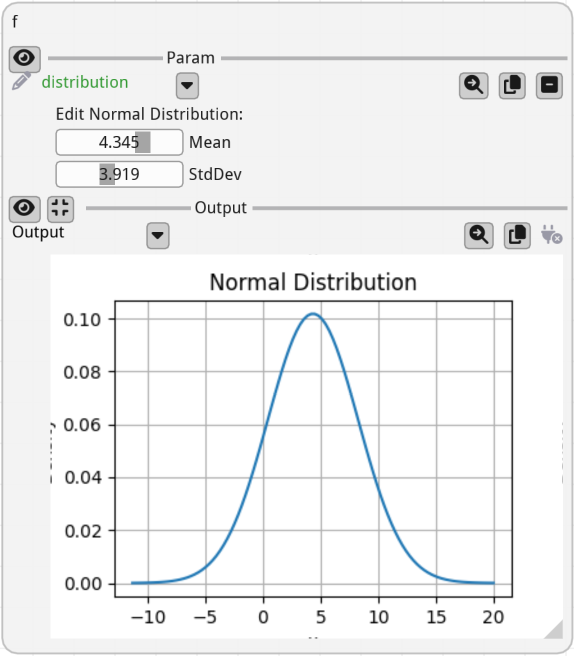

In [4]:
def f(distribution: NormalDistribution) -> NormalDistribution:
    return distribution

fl.run(f, app_name="Normal Distribution")

Example 2: a Length type with imperial units
--------------------------------------------

2024-07-04 23:40:37.134 Python[68193:11625526] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


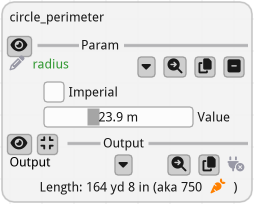

In [5]:
# Step 1: Define the custom type for which we want to create a GUI
# =================================================================
from typing import NewType

Length = NewType("Length", float)

# Step 2: Create a class to handle the custom type
# ================================================
import fiatlight
from fiatlight import AnyDataWithGui
from fiatlight.fiat_widgets import fontawesome_6_ctx, icons_fontawesome_6
from typing import NewType, Any, Dict
from imgui_bundle import imgui, hello_imgui, imgui_ctx, ImVec4


# The specific GUI for our custom type
class LengthWithGui(AnyDataWithGui[Length]):
    use_imperial_units: bool = False

    def __init__(self) -> None:
        super().__init__(Length)
        self.callbacks.edit = self._edit  # A custom callback for editing the data
        self.callbacks.present = self._present  # A custom callback for presenting the data
        self.callbacks.present_str = self._present_str  # A custom callback for presenting the data as a short string
        self.callbacks.default_value_provider = lambda: Length(1.0)  # A custom callback for providing a default value
        # custom callback for saving the GUI options (here, we save the imperial units option)
        self.callbacks.save_gui_options_to_json = self._save_gui_options_to_json
        self.callbacks.load_gui_options_from_json = self._load_gui_options_from_json

    def _edit(self, value: Length) -> tuple[bool, Length]:
        _, self.use_imperial_units = imgui.checkbox("Imperial", self.use_imperial_units)

        format = "%.3g m" if not self.use_imperial_units else "%.3g yd"
        value_unit = value * 1.09361 if self.use_imperial_units else value
        imgui.set_next_item_width(hello_imgui.em_size(10))
        changed, new_value_unit = imgui.slider_float(
            "Value", value_unit, 1e-5, 1e11, format, imgui.SliderFlags_.logarithmic.value
        )
        if changed:
            value = Length(new_value_unit / 1.09361 if self.use_imperial_units else new_value_unit)
        return changed, value

    @staticmethod
    def _present_str(value: Length) -> str:
        return f"Length: {value:.2f} m"

    @staticmethod
    def _present(value: Length) -> None:
        with fontawesome_6_ctx():
            yd = int(Length(value * 1.09361))
            inches = int((Length(value * 1.09361 - yd) * 36))
            bananas = int(value / 0.2)
            imgui.text(f"Length: {yd} yd {inches:.0f} in (aka {bananas}")
            imgui.same_line()
            with imgui_ctx.push_style_color(imgui.Col_.text.value, ImVec4(1, 0.5, 0, 1)):
                imgui.text(icons_fontawesome_6.ICON_FA_CARROT)
            imgui.same_line()
            imgui.text(")")

    def _save_gui_options_to_json(self) -> Dict[str, Any]:
        return {"use_imperial_units": self.use_imperial_units}

    def _load_gui_options_from_json(self, json: Dict[str, Any]) -> None:
        self.use_imperial_units = json.get("use_imperial_units", False)


# Step 3: Register the custom type with its GUI
# ==============================================
from fiatlight import register_type

register_type(Length, LengthWithGui)


# Step 4: Use the custom type in a function
# =========================================
# A function that uses our custom type
def circle_perimeter(radius: Length) -> Length:
    return Length(2 * 3.14159 * radius)


# Run the function with the GUI
fiatlight.run(circle_perimeter, app_name="Circle Perimeter in banana units")

Example 3: a sound player
-------------------------

The sound wave player also uses a custom type with a GUI.

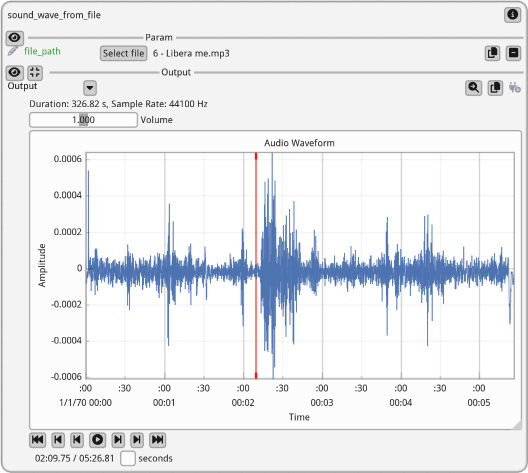

In [6]:
from fiatlight.fiat_kits.experimental.fiat_audio_simple.demos import demo_sound_wave_player

sound_wave_player_gui_demo.main()

For more info, see its [source code](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiat_kits/experimental/fiat_audio_simple/sound_wave_player_gui.py)).


How to create a new "fiat kit"
==============================

fiat_kit_skeleton
-----------------

[fiatlight.fiat_kits.fiat_skeleton](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiatlight/fiat_kits/fiat_kit_skeleton) is a starting point for creating new widgets: it is a minimalistic kit that contains the necessary files to create a new widget.

    fiat_kit_skeleton
    ├── __init__.py
    ├── mydata.py                      # An example data or library that you want to present
    ├── mydata_presenter.py            # The presenter of the data
    |                                  # Also contains a derivate of PossibleCustomAttributes
    |                                  # where all the custom attributes are defined
    |
    └── mydata_with_gui.py             # MyDataWithGui: the widget that will be displayed in the GUI
    # (inherits from AnyDataWithGui, implements all the callbacks
    #  of AnyDataGuiCallbacks, and uses MyDataPresenter for
    # complex data presentation)


See files:
* [mydata.py](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiatlight/fiat_kits/fiat_kit_skeleton/mydata.py)
* [mydata_presenter.py](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiatlight/fiat_kits/fiat_kit_skeleton/mydata_presenter.py)
* [mydata_with_gui.py](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiatlight/fiat_kits/fiat_kit_skeleton/mydata_with_gui.py)


fiat_kit_skeleton in action
---------------------------

[fiatlight.fiat_kits.fiat_dataframe](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiatlight/fiat_kits/fiat_dataframe) it was developed starting from the skeleton. It is a good example on how it can be customized.

    fiat_dataframe
    ├── dataframe_presenter.py                  # The presenter of the data (presentation code)
    |                                           # Also contains a derivate of PossibleCustomAttributes
    |
    ├── dataframe_with_gui.py                   # The widget that will be displayed in the GUI
    |                                           # (inherits from AnyDataWithGui, implements all the callbacks
    |                                          #  of AnyDataGuiCallbacks, and uses DataFramePresenter for
    |                                          # complex data presentation)

See files:

* [dataframe_presenter.py](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiatlight/fiat_kits/fiat_dataframe/dataframe_presenter.py)
* [dataframe_with_gui.py](https://github.com/pthom/fiatlight/tree/refact_io/src/python/fiatlight/fiatlight/fiat_kits/fiat_dataframe/dataframe_with_gui.py)